## Double descent in Deep Networks

This notebook contains the relevant code for the following figures in the paper "*Early stopping in deep networks: Double descent and how to eliminate it*":

- Figure 1-a
- Figure 4

In [1]:
%matplotlib inline
import pathlib
import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

import sys
repo_root = str((pathlib.Path.cwd().parent / 'code').resolve())
sys.path.append(repo_root)
import plot_utils

out_dir = pathlib.Path.cwd().parent / 'results/mcnn/cifar/'

### Figure 1-a: Epoch-wise double descent in 5-layer CNN

- The test error of an overparameterized 5-layer convolutional network trained on a noisy version of the CIFAR-10 training set (20% random label noise) as a function of training epochs.
- As observed by Nakkiran et al. (2019), the performance shows a double descent behavior.
- **Bias-variance:** Bias-variance computation was implemented as proposed in Yang et al. (2020) but for each training epoch instead of at the end of training. Note that this results in a highly noisy measurement, especially for the early training phase. To address this issue, the measurements were averaged across randomizations. 

<sub>Preetum Nakkiran, Gal Kaplun, Yamini Bansal, Tristan Yang, Boaz Barak, and Ilya Sutskever. Deep Double Descent: Where Bigger Models and More Data Hurt. *arXiv:1912.02292 \[cs, stat\]*, 2019.</sub>
<sub>Zitong Yang, Yaodong Yu, Chong You, Jacob Steinhardt, and Yi Ma. Rethinking Bias-Variance Trade-off for Generalization of Neural Networks. In International Conference on Machine Learning, 2020.</sub>

In [2]:
# read results
out_file = out_dir / 'base' / 'log.json'
epoch_arr, acc_log = plot_utils.readJsonLog(out_file)

In [3]:
# read bias variance results
out_file_bv = out_dir / 'bias_variance' / 'mcnn_bias_variance.txt'
bivar_np = np.loadtxt(out_file_bv, skiprows=1)

bivar_log = {'bias': bivar_np[:,1]/10, 'variance': bivar_np[:,2]/10}
bivar_epoch_arr = bivar_np[:,0]

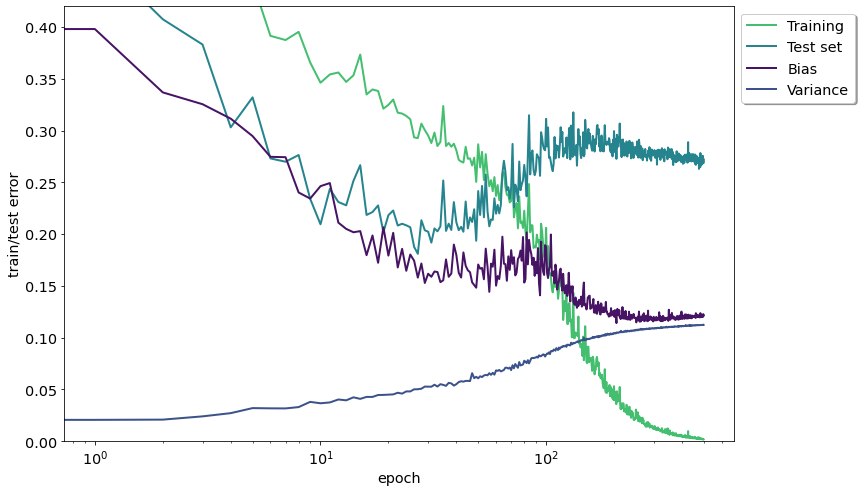

In [4]:
# plot setup
xrange = 500
cmap = matplotlib.cm.get_cmap('viridis')
colorList = [cmap(700/1000), cmap(450/1000), cmap(50/1000), cmap(250/1000)]
labelList = [r'Training', r'Test set', r'Bias', r'Variance']

# plot results
fig = plt.figure(figsize=(12,8))
ax = plt.subplot(111)  
for i, setkey in enumerate(acc_log.keys()):
    ax.semilogx(epoch_arr[:xrange], 1-np.array(acc_log[setkey][:xrange])/100, lw = 2, color = colorList[i], label=labelList[i])

for i, setkey in enumerate(bivar_log.keys()):
    ax.semilogx(bivar_epoch_arr[:xrange], 2*bivar_log[setkey][:xrange], lw = 2, color = colorList[i+2], label=labelList[i+2])
   

    
# plot metadata
ax.legend(loc=2, bbox_to_anchor=(1, 1), fontsize='x-large',
          frameon=True, fancybox=True, shadow=True, ncol=1)
ax.set_ylabel('train/test error')
ax.set_xlabel('epoch')
ax.set_ylim((0, 0.42))

# show plot
plt.show()

### Figure 4: Eliminating double descent: Jacobian norm and scaling the learning rate

- Mitigating double descent for 5-layer CNN.

**Left:** The Frobenius norm of the Jacobian associated with the convolutional layer and the fully connected layer across training iterations.


**Right:** Test error of the CNN trained with the i) same stepsize for all layers, ii) a smaller and iii) larger stepsize for the last fully connected layer.

Decreasing the learning rate of the last layer causes the last layer to be learned at a similar speed to the convolutional layer and thereby eliminates double descent and increases the best early-stopped performance (the minima of ii is smaller than that of i and iii). 

In [5]:
# 5-layer CNN model setup
MODEL_LAYER_TYPES = {'conv': [0, 3, 7, 11],
                     'batchnorm': [1, 4, 8, 12],
                     'linear': [17]}

MODEL_NUM_PARAMS = {'0': [64, 3, 3, 3],
                    '3': [128, 64, 3, 3],
                    '7': [256, 128, 3, 3],
                    '11': [512, 256, 3, 3],
                    '17': [10, 512]}

In [6]:
# read results for the Jacobian plot
out_file_jac = out_dir / 'jacobian' / 'jacobian_svd.npz'
jac_npz = np.load(out_file_jac)

sv = jac_npz['sv']
v1 = jac_npz['vconv']
v2 = jac_npz['vfc']


# read results for the test error plots
out_files = {'base': out_dir / 'base' / 'log.json', 
             'no_dd': out_dir / 'ff_small_lr' / 'log.json', 
             'ex_dd': out_dir / 'ff_large_lr' / 'log.json'}
epoch_arrs, acc_logs = {}, {}
for cur_set, out_file in out_files.items():
    epc, acc = plot_utils.readJsonLog(out_file)
    epoch_arrs.update({cur_set: np.array(epc)})
    acc_logs.update({cur_set: {'test' : np.array(acc['test']), 'train' : np.array(acc['train'])}})

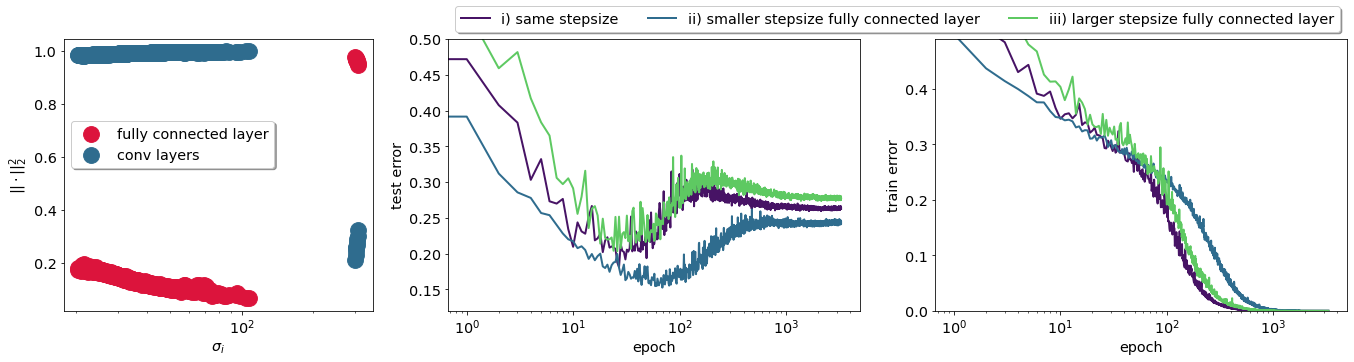

In [7]:
# plot setup
xrange = 3300
cmap = matplotlib.cm.get_cmap('viridis')
plot_setup = {k: {} for k in ['jacobian', 'err']}
plot_setup['jacobian'].update({'colors': ['crimson', cmap(350/1000)]})
plot_setup['jacobian'].update({'layers': ['fully connected layer', 'conv layers']})
plot_setup['err'].update({'colors': [cmap(50/1000), cmap(350/1000), cmap(750/1000)]})
plot_setup['err'].update({'layers': ['i) same stepsize', 
                                     'ii) smaller stepsize fully connected layer', 
                                     'iii) larger stepsize fully connected layer']})



# plot Jacobian
fig = plt.figure(figsize=(23,5))
gs = matplotlib.gridspec.GridSpec(1, 3, width_ratios=[1.5, 2, 2]) 
ax1 = plt.subplot(gs[0])  

ax1.scatter(sv, v2, 
            color=plot_setup['jacobian']['colors'][0], 
            label=plot_setup['jacobian']['layers'][0],
            s=250)
ax1.scatter(sv, v1, 
            color=plot_setup['jacobian']['colors'][1], 
            label=plot_setup['jacobian']['layers'][1],
            s=250)
        
    
# plot test errors
ax2 = plt.subplot(gs[1])  
for i, (cur_set, cur_err) in enumerate(acc_logs.items()):
    ax2.semilogx(epoch_arrs[cur_set][:xrange], 1-cur_err['test'][:xrange]/100, lw = 2,
                 color = plot_setup['err']['colors'][i], 
                 label = plot_setup['err']['layers'][i])
    
    
# plot train errors
ax3 = plt.subplot(gs[2])  
for i, (cur_set, cur_err) in enumerate(acc_logs.items()):
    ax3.semilogx(epoch_arrs[cur_set][:xrange], 1-cur_err['train'][:xrange]/100, lw = 2,
                 color = plot_setup['err']['colors'][i], 
                 label = plot_setup['err']['layers'][i])
    
# plot metadata
ax1.legend(loc=3, bbox_to_anchor=(0, 0.5),
          frameon=True, fancybox=True, shadow=True, ncol=1)
ax1.set_ylabel(r'$\left || \cdot \right ||_2^2$')
ax1.set_xlabel(r'$\sigma_i$')
ax1.set_xscale('log')

ax2.set_xlabel('epoch')
ax2.set_ylabel('test error')
ax2.set_ylim((0.12, 0.5))

ax3.legend(loc=4, bbox_to_anchor=(1, 1),
          frameon=True, fancybox=True, shadow=True, ncol=3)
ax3.set_xlabel('epoch')
ax3.set_ylabel('train error')
ax3.set_ylim((0, 0.49))

# show plot
plt.show()